<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Hang Glider Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Hang Glider Problem:* We aim to maximize the final horizontal position of the glider while in the presence of a thermal updraft.

The problem is inspired from the following paper: [Benchmarking Optimization Software with COPS 3.0](https://www.mcs.anl.gov/~more/cops/cops3.pdf).                             
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

## 1. Solving with JuMP <a id='jump'></a>

In [1]:
using JuMP , Ipopt
include("../Problems/JuMP/glider_JMP.jl")
nh = 100 
N = nh
GliderJMP = glider_JMP(;nh=100)

set_optimizer(GliderJMP,Ipopt.Optimizer)
set_attribute(GliderJMP, "print_level", 5)
set_optimizer_attribute(GliderJMP,"tol",1e-8)
set_optimizer_attribute(GliderJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(GliderJMP,"max_iter",1000)
set_optimizer_attribute(GliderJMP,"mu_strategy","adaptive")
set_optimizer_attribute(GliderJMP,"linear_solver","mumps")

In [2]:
println("Solving...")
optimize!(GliderJMP)
println()

# Display results
if termination_status(GliderJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(GliderJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(GliderJMP) == MOI.TIME_LIMIT && has_values(GliderJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(GliderJMP))
println()

# Retrieves values (including duals - sign convention according to Pontrjagin max principle)
a = 100.0 
u_min, u_max = -pi/2.0, pi/2.0
xs = zeros(4)
xf = [NaN, 5.0, 45.0, 0.0]

x_ = GliderJMP[:x];
y_ = GliderJMP[:y];
x_dot = GliderJMP[:vx_dot];
y_dot = GliderJMP[:vy_dot];
u_ = GliderJMP[:cL];

con_x1 = GliderJMP[:x_eqn];
con_x2 = GliderJMP[:y_eqn];
con_x3 = GliderJMP[:vx_eqn];
con_x4 = GliderJMP[:vy_eqn];

tf = value(GliderJMP[:t_f])
Δtt = value.(tf)/N
t = Vector((0:N)*Δtt); 

p = [ [ dual(con_x1[N]), dual(con_x2[N]), dual(con_x3[N]), dual(con_x4[N]) ] ];
p = - [[[ dual(con_x1[i]), dual(con_x2[i]), dual(con_x3[i]), dual(con_x4[i]) ] for i in 1:N];p ];



x1 = Vector(value.(x_))
x2 = Vector(value.(y_))
x3 = Vector(value.(x_dot))
x4 = Vector(value.(y_dot))
u = Vector(value.(u_)) ;

x =  [ [ x1[i], x2[i], x3[i], x4[i] ] for i in 1:N+1] ;


Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     3007
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     9400

Total number of variables............................:      506
                     variables with only lower bounds:      203
                variables with lower and upper bounds:      101
                     variables with only upper bounds:        0
Total number of equality constraints.................:      407
Total number of i

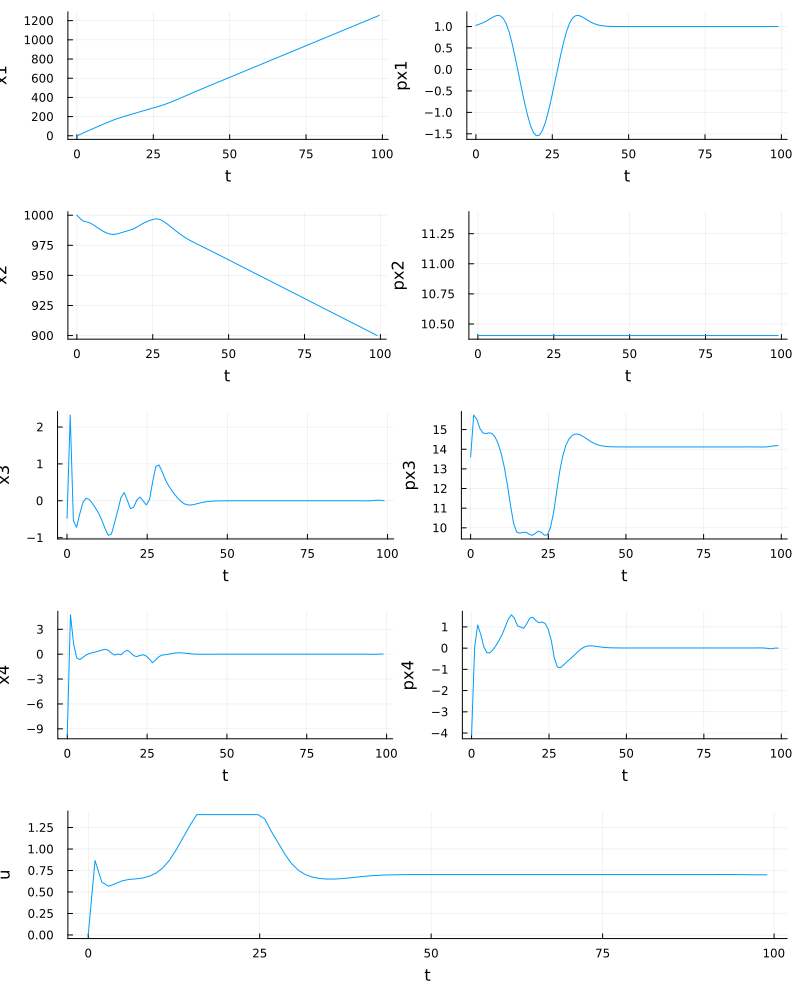

In [3]:
using Plots

x1_plot = plot(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "x1", legend = false)
x2_plot = plot(t, [ x[i][2] for i in 1:N+1], xlabel = "t", ylabel = "x2", legend = false)
x3_plot = plot(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "x3", legend = false)
x4_plot = plot(t, [ x[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "x4", legend = false)
px1_plot = plot(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "px1", legend = false)
px2_plot = plot(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "px2", legend = false)
px3_plot = plot(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "px3", legend = false)
px4_plot = plot(t, [ p[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "px4", legend = false)
u_plot = plot(t, [ u[i] for i in 1:N+1 ], xlabel = "t", ylabel = "u", legend = false)

layout = @layout [a b; c d; e f; g h; k]
x_plot = plot(x1_plot, px1_plot, x2_plot, px2_plot, x3_plot, px3_plot, x4_plot, px4_plot, u_plot, layout = layout, size = (800, 1000))
display(x_plot)

## 2. Solving with OptimalControl <a id='oc'></a>

In [4]:
using OptimalControl
include("../Problems/OptimalControl/glider_OC.jl")
GliderOC = glider_OC()


The (autonomous) optimal control problem is given by:

    x_0 = 0.0
    y_0 = 1000.0
    y_f = 900.0
    vx_0 = 13.23
    vx_f = 13.23
    vy_0 = -1.288
    vy_f = -1.288
    u_c = 2.5
    r_0 = 100.0
    m = 100.0
    g = 9.81
    c0 = 0.034
    c1 = 0.069662
    S = 14.0
    rho = 1.13
    cL_min = 0.0
    cL_max = 1.4
    t0 = 0.0
    tf ∈ R¹, variable
    t ∈ [t0, tf], time
    x ∈ R⁴, state
    u ∈ R¹, control
    x1 = x₁
    y = x₂
    vx = x₃
    vy = x₄
    cL = u₁
    x1(t) ≥ 0.0, x_con
    vx(t) ≥ 0.0, vx_con
    cL_min ≤ cL(t) ≤ cL_max, cL_con
    x1(t0) == x_0, x0_con
    y(t0) == y_0, y0_con
    vx(t0) == vx_0, vx0_con
    vy(t0) == vy_0, vy0_con
    y(tf) == y_f, yf_con
    vx(tf) == vx_f, vxf_con
    vy(tf) == vy_f, vyf_con
    ẋ(t) == dynamics(x(t), u(t))
    x1(tf) → max

The (autonomous) optimal control problem is of the form:

    minimize  J(x, u, tf) = g(x(0.0), x(tf), tf)

    subject to

        ẋ(t) = f(x(t), u(t), tf), t in [0.0, tf] a.e.,

        ηl ≤ η(x(


┌────────┬────────┬──────────┬──────────┬───────────┬────────────┬─────────────┐
│ times* │ state* │ control* │ variable │ dynamics* │ objective* │ constraints │
├────────┼────────┼──────────┼──────────┼───────────┼────────────┼─────────────┤
│     ✅ │     ✅ │       ✅ │       ✅ │        ✅ │         ✅ │          ✅ │
└────────┴────────┴──────────┴──────────┴───────────┴────────────┴─────────────┘


In [5]:
# Initial guess
x_0 = 0.0
y_0 = 1000.0
y_f = 900.0
vx_0 = 13.23
vy_0 = -1.288
cL_max = 1.4

xinit = t -> [x_0 + vx_0*t,
        y_0 + t*(y_f - y_0),
        vx_0 ,
        vy_0]
uinit = cL_max/2.0
init = (state = xinit, control = uinit , variable= 1.0)
# Solve the problem
sol = OptimalControl.solve(GliderOC,init = init, grid_size = nh, tol=1e-8,constr_viol_tol=1e-6)

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     2807
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1414

Total number of variables............................:      506
                     variables with only lower bounds:      202
                variables with lower and upper bounds:      101
                     variables with only upper bounds:        0
Total number of equality constraints.................:      407
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.3230000e+01 9.87e-01 3.02e-01   0.

CTBase.OptimalControlSolution

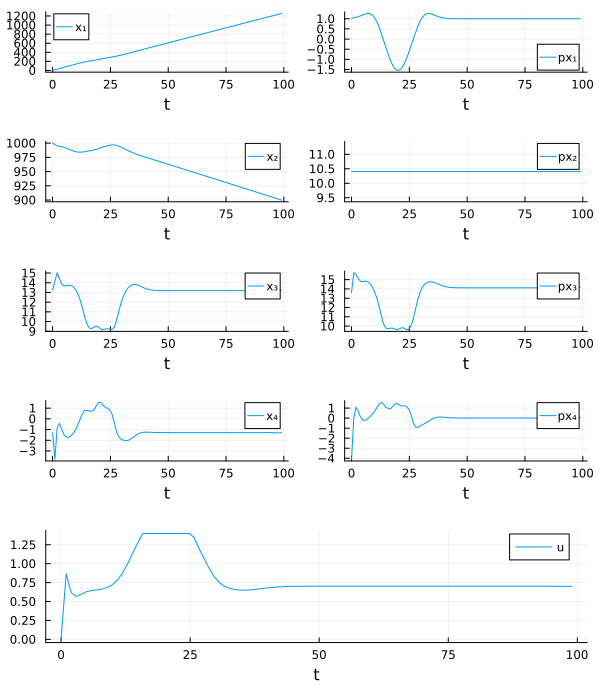

In [6]:
plot(sol)

## 3. Comparison <a id='comp'></a>

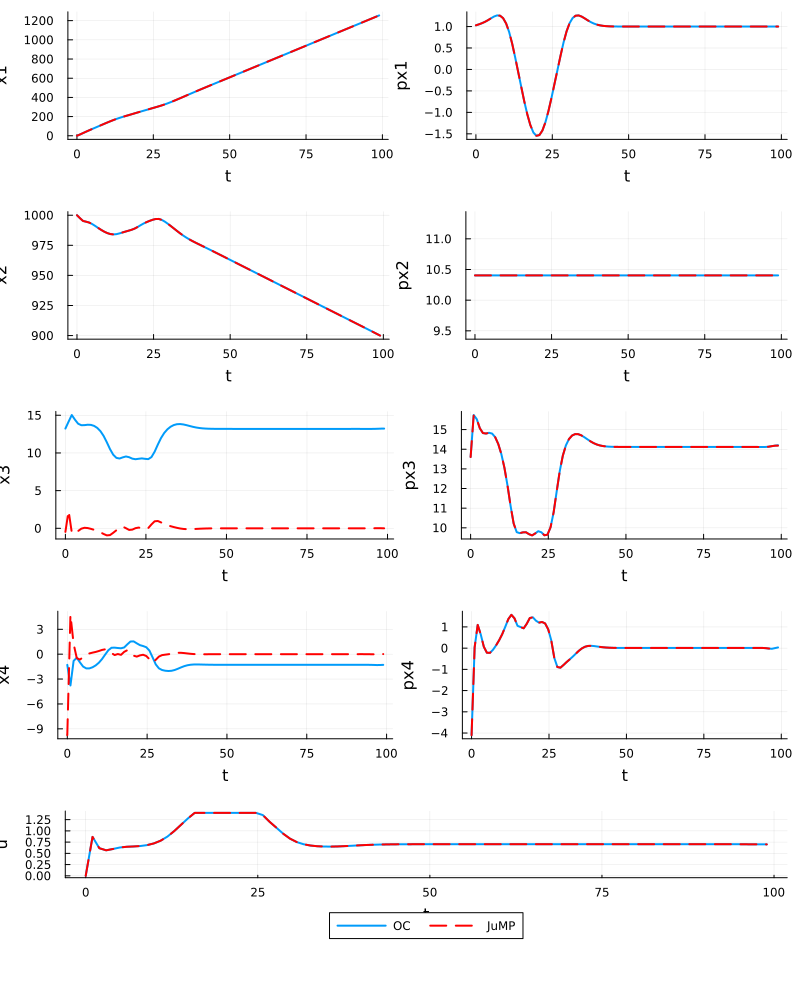

In [7]:
using Plots
p1 = plot(plot(sol)[1],line = 2)
p1 = plot!(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "x1", legend = false,line = 2, color = "red",linestyle=:dash)

p3 = plot(plot(sol)[2],line = 2)
p3 = plot!(t, [ x[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "x2", legend = false,line = 2, color = "red",linestyle=:dash)

p5 = plot(plot(sol)[3],line = 2)
p5 = plot!(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "x3", legend = false,line = 2, color = "red",linestyle=:dash)

p7 = plot(plot(sol)[4],line = 2)
p7 = plot!(t, [ x[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "x4", legend = false,line = 2, color = "red",linestyle=:dash)

p2 = plot(plot(sol)[5],line = 2)
p2 = plot!(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "px1", legend = false,line = 2, color = "red",linestyle=:dash)

p4 = plot(plot(sol)[6],line = 2)
p4 = plot!(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "px2", legend = false,line = 2, color = "red",linestyle=:dash)

p6 = plot(plot(sol)[7],line = 2)
p6 = plot!(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "px3", legend = false,line = 2, color = "red",linestyle=:dash)

p8 = plot(plot(sol)[8],line = 2)
p8 = plot!(t, [ p[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "px4", legend = false,line = 2, color = "red",linestyle=:dash)

p9 = plot(plot(sol)[9] , label ="OC",line = 2)
p9 = plot!(t, [u[i] for i in 1:N+1 ], xlabel = "t", ylabel = "u", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
p9 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; e f; g h; k]
x_plot = plot(p1, p2, p3, p4, p5, p6, p7 , p8, p9, layout = layout, size = (800, 1000))

display(x_plot)
